# Predicción de Riesgo Crediticio con Support Vector Machines (SVM)
**Autora:** Nancy Borges
**Objetivo:** Clasificar el riesgo de clientes bancarios utilizando un Kernel RBF para manejar relaciones no lineales.

In [12]:
#Generación de Datos Sintéticos y Lógica de Negocio Se genera una muestra de 1000 registros simulando 
#perfiles crediticios para validar la capacidad del modelo SVM de identificar patrones de riesgo complejos.

import pandas as pd
import numpy as np

# 1. Configuramos para que siempre genere los mismos datos
np.random.seed(42)

# 2. Definimos las opciones para las columnas de texto
sex_opt = ['male', 'female']
housing_opt = ['own', 'rent', 'free']
savings_opt = ['little', 'moderate', 'quite rich', 'rich', np.nan]
checking_opt = ['little', 'moderate', 'rich', np.nan]
purpose_opt = ['radio/TV', 'education', 'furniture/equipment', 'car', 'business']

# 3. Generamos las 1000 filas
n = 1000
data = {
    'Age': np.random.randint(18, 75, n),
    'Sex': np.random.choice(sex_opt, n),
    'Job': np.random.randint(0, 4, n),
    'Housing': np.random.choice(housing_opt, n),
    'Saving accounts': np.random.choice(savings_opt, n),
    'Checking account': np.random.choice(checking_opt, n),
    'Credit amount': np.random.randint(250, 15000, n),
    'Duration': np.random.randint(6, 72, n),
    'Purpose': np.random.choice(purpose_opt, n)
}

df_final = pd.DataFrame(data)

# 4. CREAMOS EL "RISK" (Lógica: Si es mucha plata a mucho tiempo, hay más riesgo)
# Definimos riesgo 'bad' si el monto es alto y la duración es larga
def definir_riesgo(row):
    if (row['Credit amount'] > 8000 and row['Duration'] > 36) or (row['Age'] < 22 and row['Credit amount'] > 5000):
        return 'bad'
    else:
        return 'good'

df_final['Risk'] = df_final.apply(definir_riesgo, axis=1)


print(df_final.head())

   Age     Sex  Job Housing Saving accounts Checking account  Credit amount  \
0   56    male    1     own            rich         moderate          12408   
1   69  female    2     own            rich              nan          12155   
2   46    male    3    rent            rich           little          12568   
3   32  female    2     own            rich           little           7792   
4   60    male    1    rent            rich             rich          12548   

   Duration    Purpose  Risk  
0        37        car   bad  
1        71  education   bad  
2        17        car  good  
3        45   radio/TV  good  
4        15   radio/TV  good  


In [13]:
df_final.isnull().sum()

Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
Risk                0
dtype: int64

In [14]:
df_final.shape

(1000, 10)

In [15]:
df_final.describe()

,Age,Job,Credit amount,Duration
count,1000.000000,1000.00000,1000.000000,1000.000000
mean,46.247000,1.47600,7630.851000,38.319000
std,16.288072,1.12191,4350.196334,18.936151
min,18.000000,0.00000,261.000000,6.000000
25%,33.000000,0.00000,3680.250000,22.000000
50%,46.000000,1.00000,7638.000000,38.000000
75%,60.250000,2.00000,11401.000000,55.000000
max,74.000000,3.00000,14969.000000,71.000000


In [16]:
df_final.info()

<class 'pandas.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Age               1000 non-null   int32
 1   Sex               1000 non-null   str  
 2   Job               1000 non-null   int32
 3   Housing           1000 non-null   str  
 4   Saving accounts   1000 non-null   str  
 5   Checking account  1000 non-null   str  
 6   Credit amount     1000 non-null   int32
 7   Duration          1000 non-null   int32
 8   Purpose           1000 non-null   str  
 9   Risk              1000 non-null   str  
dtypes: int32(4), str(6)
memory usage: 94.7 KB


#Análisis Exploratorio de Datos (EDA)

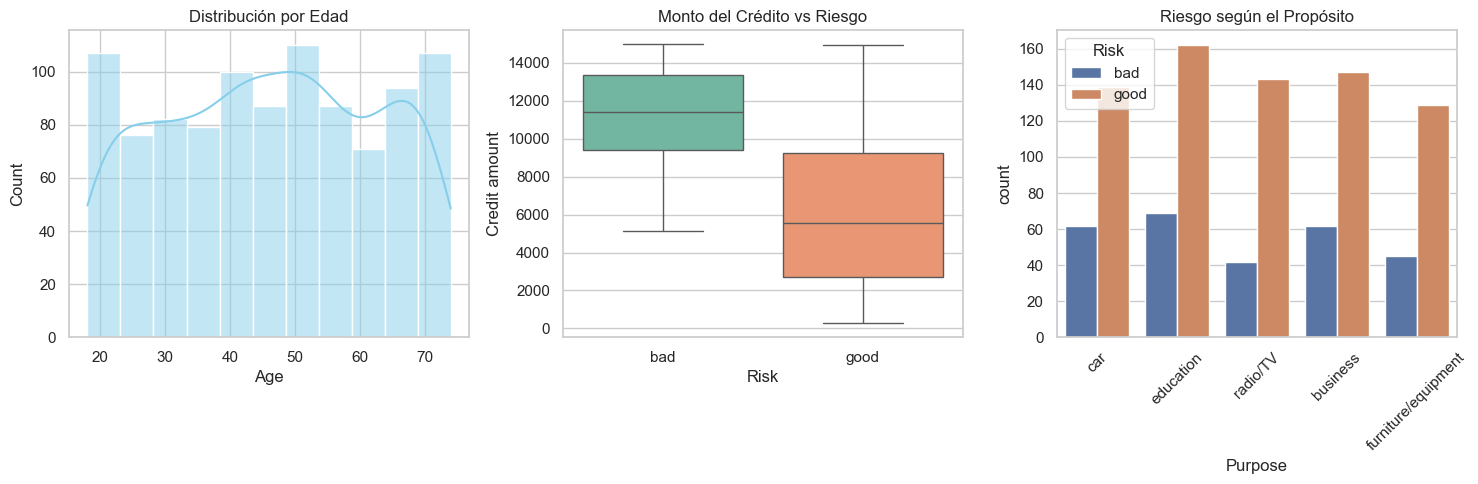

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Configuramos el estilo 
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 5))

# 1. ¿A qué edad se pide más crédito? (Distribución de Edad)
plt.subplot(1, 3, 1)
sns.histplot(df_final['Age'], kde=True, color='skyblue')
plt.title('Distribución por Edad')

# 2. ¿Cuánto dinero se pide normalmente? (Distribución de Monto)
plt.subplot(1, 3, 2)
# Versión corregida para que no tire el Warning
sns.boxplot(x='Risk', y='Credit amount', data=df_final, hue='Risk', palette='Set2', legend=False)
plt.title('Monto del Crédito vs Riesgo')

# 3. ¿Cómo influye el propósito del crédito en el riesgo?
plt.subplot(1, 3, 3)
sns.countplot(x='Purpose', hue='Risk', data=df_final)
plt.xticks(rotation=45)
plt.title('Riesgo según el Propósito')

plt.tight_layout()
plt.show()

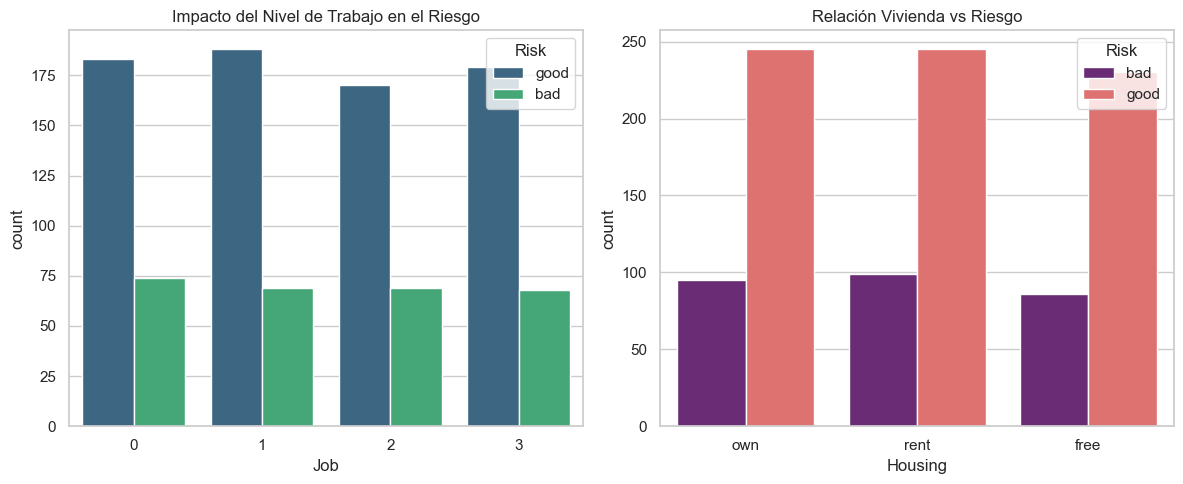

In [19]:
plt.figure(figsize=(12, 5))

# 1. Riesgo según el Tipo de Trabajo (Job)
plt.subplot(1, 2, 1)
sns.countplot(x='Job', hue='Risk', data=df_final, palette='viridis')
plt.title('Impacto del Nivel de Trabajo en el Riesgo')

# 2. Riesgo según la Vivienda (Housing)
plt.subplot(1, 2, 2)
sns.countplot(x='Housing', hue='Risk', data=df_final, palette='magma')
plt.title('Relación Vivienda vs Riesgo')

plt.tight_layout()
plt.show()

In [21]:
from sklearn.preprocessing import LabelEncoder

# Creamos una copia para no romper la base original
df_ml = df_final.copy()

# 1. Transformamos el Riesgo: 'good' -> 0, 'bad' -> 1
df_ml['Risk'] = df_ml['Risk'].map({'good': 0, 'bad': 1})

# 2. Transformamos el resto de las columnas de texto
le = LabelEncoder()
columnas_texto = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']

for col in columnas_texto:
    # Convertimos a string por si hay algún NaN (nulo) y luego a número
    df_ml[col] = le.fit_transform(df_ml[col].astype(str))


print(df_ml.head())

   Age  Sex  Job  Housing  Saving accounts  Checking account  Credit amount  \
0   56    1    1        1                4                 1          12408   
1   69    0    2        1                4                 2          12155   
2   46    1    3        2                4                 0          12568   
3   32    0    2        1                4                 0           7792   
4   60    1    1        2                4                 3          12548   

   Duration  Purpose  Risk  
0        37        1     1  
1        71        2     1  
2        17        1     0  
3        45        4     0  
4        15        4     0  


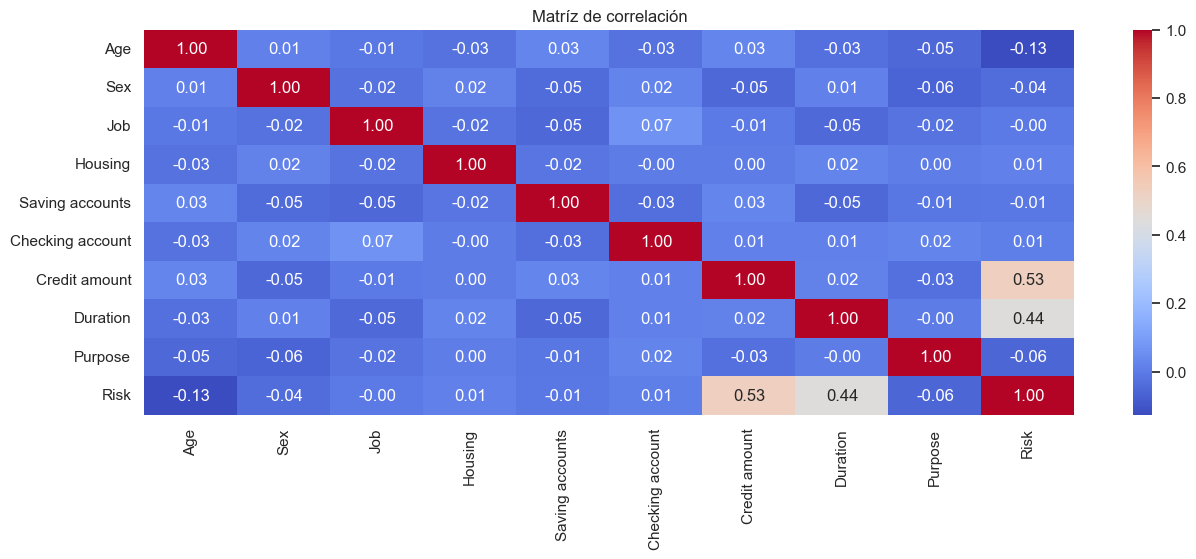

In [24]:
def gradicar_matriz_correlacion():
    matriz_correlacion=df_ml.corr(numeric_only=True)
    plt.figure(figsize=(15,5))
    plt.title('Matríz de correlación')
    sns.heatmap(matriz_correlacion, annot=True,cmap='coolwarm', fmt=".2f")
    plt.show()
gradicar_matriz_correlacion() 

#Preprocesamiento y Escalado Robusto

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import RobustScaler 

# 1. Definimos X e y
X = df_ml.drop('Risk', axis=1)
y = df_ml['Risk']

# 2. Escalado Robusto: Trata bien a los outliers sin borrarlos
scaler = RobustScaler() 
X_scaled = scaler.fit_transform(X)

# 3. Entrenamos el Kernel RBF 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
modelo_rbf_robusto = SVC(kernel='rbf', C=1.0, gamma='scale')
modelo_rbf_robusto.fit(X_train, y_train)
y_pred= modelo_rbf_robusto.predict(X_test)


#Entrenamiento del Modelo SVM (Kernel RBF)

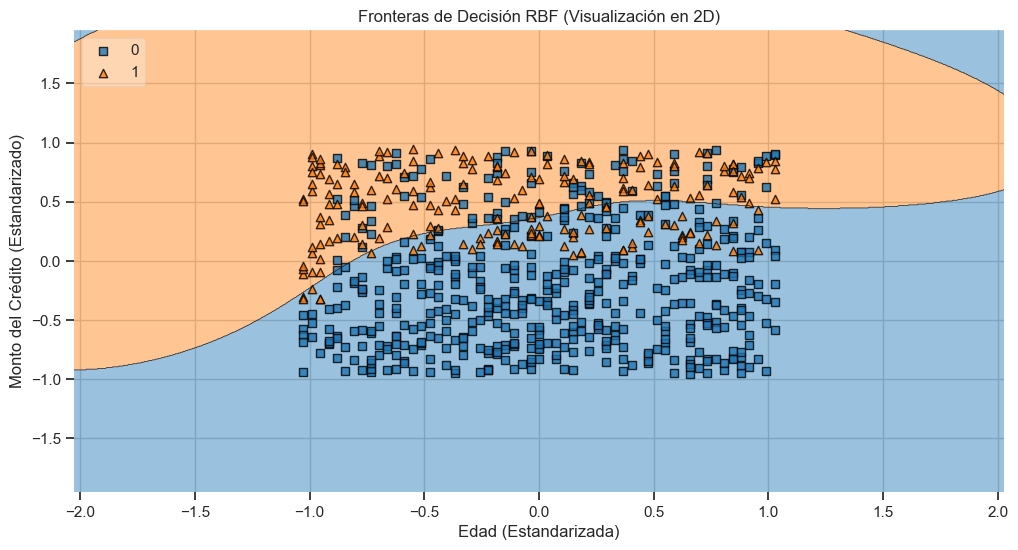

In [41]:
#import numpy as np
#import matplotlib.pyplot as plt
#from mlxtend.plotting import plot_decision_regions
#from sklearn.svm import SVC
#import warnings
#warnings.filterwarnings('ignore')

x_visual=X_train[:,[0,6]]
y_visual=y_train.to_numpy()
svm_visual= SVC(kernel='rbf', C=1.0, gamma='scale')
svm_visual.fit(x_visual, y_visual)

plt.figure(figsize=(12,6))
plot_decision_regions(x_visual, y_visual, clf=svm_visual, legend=2)
#agregar ejes
plt.xlabel('Edad (Estandarizada)')
plt.ylabel('Monto del Crédito (Estandarizado)')
plt.title('Fronteras de Decisión RBF (Visualización en 2D)')
plt.show()

#Evaluación de Métricas y Conclusiones

In [29]:
from sklearn import metrics

#consultar accuracy del modelo
print('Accuracy:',metrics.accuracy_score(y_test,y_pred))

#consultar precisión del modelo
print('Precisión:', metrics.precision_score(y_test, y_pred))

#consultar Recall del modelo
print('Recall:', metrics.recall_score(y_test, y_pred))



Accuracy: 0.9333333333333333
Precisión: 0.9078947368421053
Recall: 0.8414634146341463


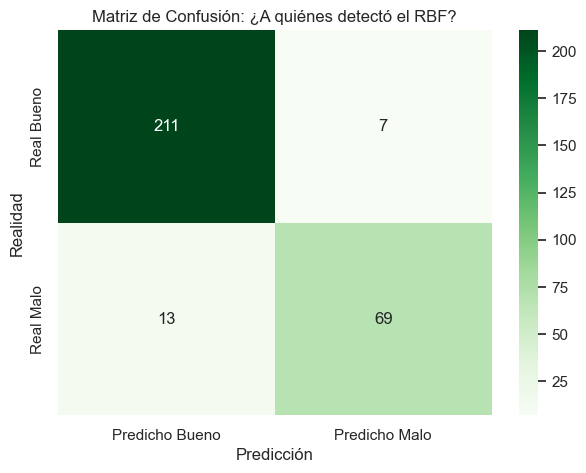

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Predicho Bueno', 'Predicho Malo'],
            yticklabels=['Real Bueno', 'Real Malo'])
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.title('Matriz de Confusión: ¿A quiénes detectó el RBF?')
plt.show()

In [32]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95       218
           1       0.91      0.84      0.87        82

    accuracy                           0.93       300
   macro avg       0.92      0.90      0.91       300
weighted avg       0.93      0.93      0.93       300



Conclusión: El modelo SVM con Kernel RBF demostró ser altamente efectivo, logrando un 93% de exactitud. El uso de RobustScaler fue clave para manejar la dispersión en los montos de crédito.